In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump, load
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn import tree


# Data dictionary & problem description:

Problem: predicting based on diagnostic measures whether or not a patient has diabetes

*   Pregnancies. Number of pregnancies of the patient (numeric)
*   Glucose. Plasma glucose concentration 2 hours after an oral glucose tolerance test (numeric)
*   BloodPressure. Diastolic blood pressure (measured in mm Hg) (numeric)
*   SkinThickness. Triceps skinfold thickness (measured in mm) (numeric)
*   Insulin. 2-hour serum insulin (measured in mu U/ml) (numeric)
*   BMI. Body mass index (numeric)
*   DiabetesPedigreeFunction. Diabetes Pedigree Function (numeric)
*   Age. Age of patient (numeric)
*   Outcome. Class variable (0 or 1), being 0 negative in diabetes and 1, positive (numeric)

# Importing data

In [2]:
url='https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
dbts_raw=pd.read_csv(url)

#Exploratory data analysis

In [3]:
dbts_raw.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

At first look there seem to be no missing values:

In [4]:
dbts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Checking for duplicated values: no duplicates

In [5]:
print(dbts_raw.duplicated().sum())

0


Patients in the sample on average:

*   Have had 3 pregnancies
*   Have glucose levels of 120, which is a normal level for this type of glucose exam (e.g., below 140)
*   Have a diastolic blood pressure of 69, which is considered normal (e.g., below 80)
*   Are 33 years old
*   Have a BMI of 31, which is outside the normal range (e.g., 18-25)
*   Roughly 35% are diagnosed with diabetes



In [6]:
dbts_raw.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

## Univariate analysis

*    There seems to be some missing data for variables such as glucose, blood pressure, skin thickness, insulin, and BMI. These variables have the value of zero in them, a value of zero does not make much sense for these variables (e.g., a patient cannot have a measure of glucose of zero). Further treatment of this variables is required to address the zero values


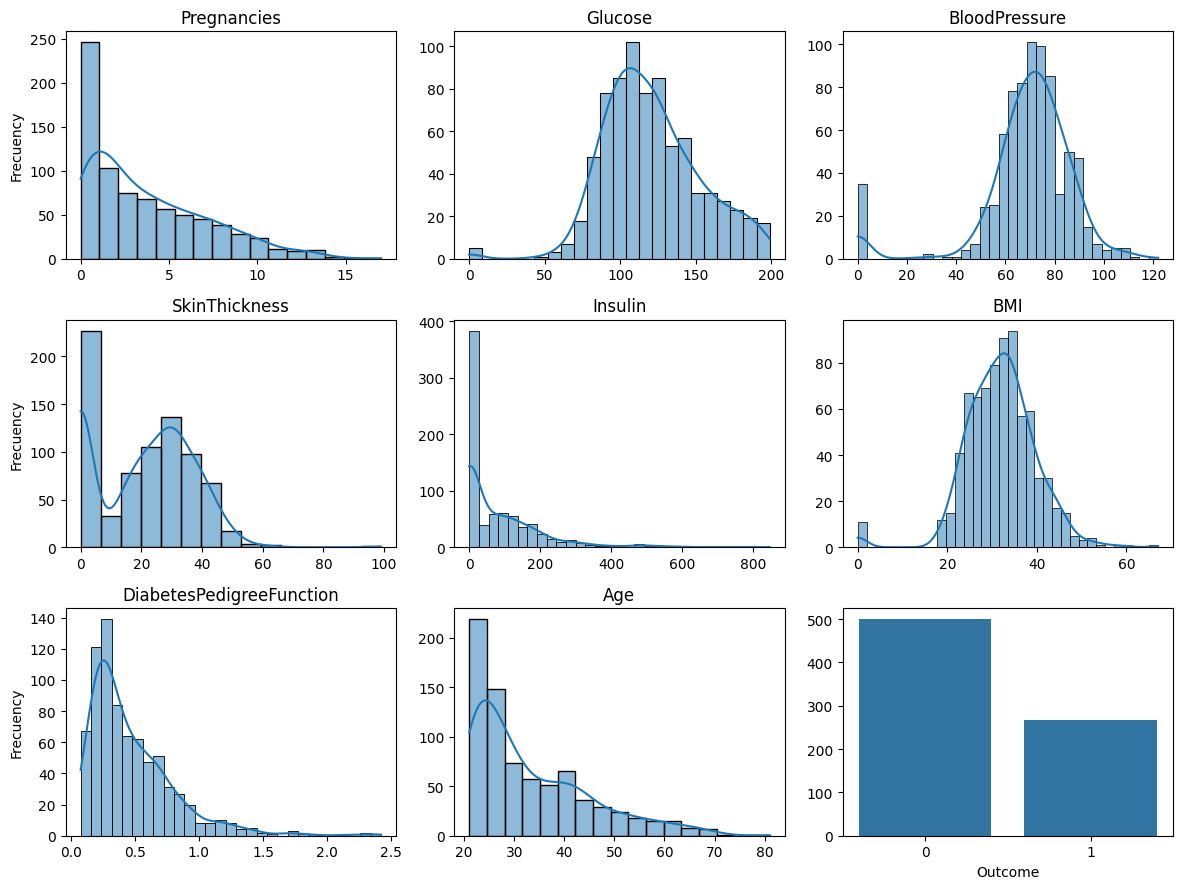

In [7]:
cols=3
rows=((len(dbts_raw.columns) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(dbts_raw.drop('Outcome', axis=1).columns , axis.flatten()):
  sns.histplot(dbts_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('')
  ax.set_xlabel('')

sns.countplot(data=dbts_raw, x='Outcome', ax=axis[2,2])

axis[0,0].set_ylabel('Frecuency')
axis[1,0].set_ylabel('Frecuency')
axis[2,0].set_ylabel('Frecuency')
axis[2,2].set_ylabel('')


#removing empty subplots
for i in range(len(dbts_raw), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

The variable insulin has a high number of zeros. This is likely a data-entry error or that the insulin level was not measured for those patientes

In [8]:
outliers=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']
for x in outliers:
  print(dbts_raw[dbts_raw[x]==0][[x]].value_counts())
  print('\n')

Glucose
0          5
Name: count, dtype: int64


BloodPressure
0                35
Name: count, dtype: int64


SkinThickness
0                227
Name: count, dtype: int64


Insulin
0          374
Name: count, dtype: int64


BMI
0.0    11
Name: count, dtype: int64




## Multivariate analysis

### Correlation matrix including missing values coded as 0:



There are no major signs of imperfect multicollinearity between variables. There is some correlation between the outcome variable and glucose, which is expected, as well as age and pregnancy.

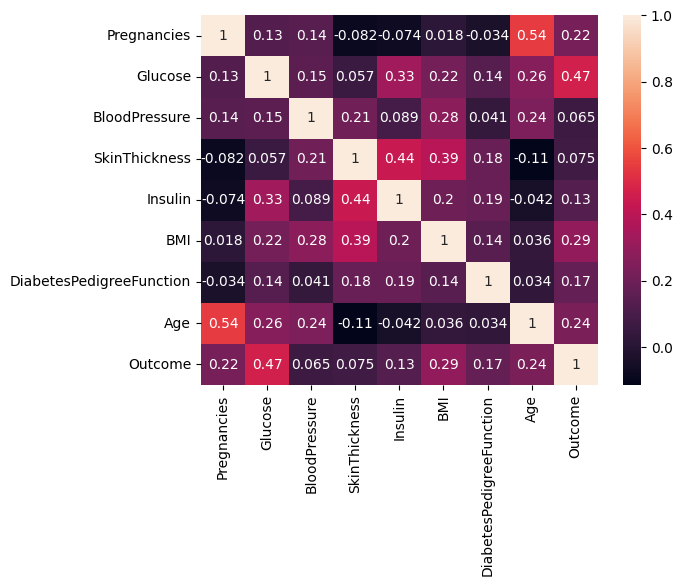

In [9]:
sns.heatmap(dbts_raw.corr(), annot=True)
plt.show()

### Correlation matrix **excluding** missing values:



Creating a new dataframe with missing values coded as NaN:

In [10]:
dbts_int=dbts_raw.copy()

for var in outliers:
  dbts_int.replace({var:0}, np.nan, inplace=True)

Here just confirming the conversion to missing data worked well:

In [11]:
dbts_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


Removing missing values does affect the relationship between the variables, especially for the variables of insulin and skin thickness, which are the ones with the highest number of missings. Now skin thickness and BMI are much more positively correlated, which is expected given that both measures are proxy indicators of adiposity. Higher skin thickness represents higher body fat, which in turn represents higher BMI

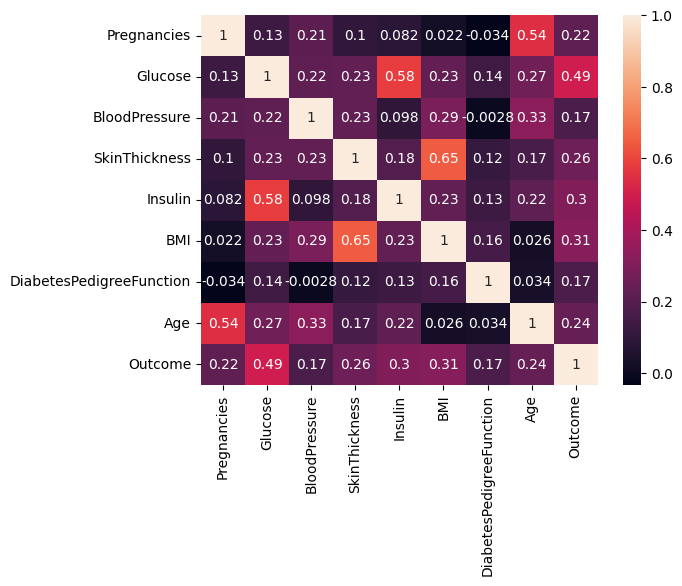

In [12]:
sns.heatmap(dbts_int.corr(), annot=True)
plt.show()

### How is the relationship between all variables (includes missings)?

*   According to the pairplot, people with diabetes tend to be positively associated with higher levels of glucose and BMI, as well as higher levels of glucose and blood pressure

*   The graph also shows the concentration of missing values (coded as zero) for some of the variables, which may skew the visualisation of their relationship with other variables.

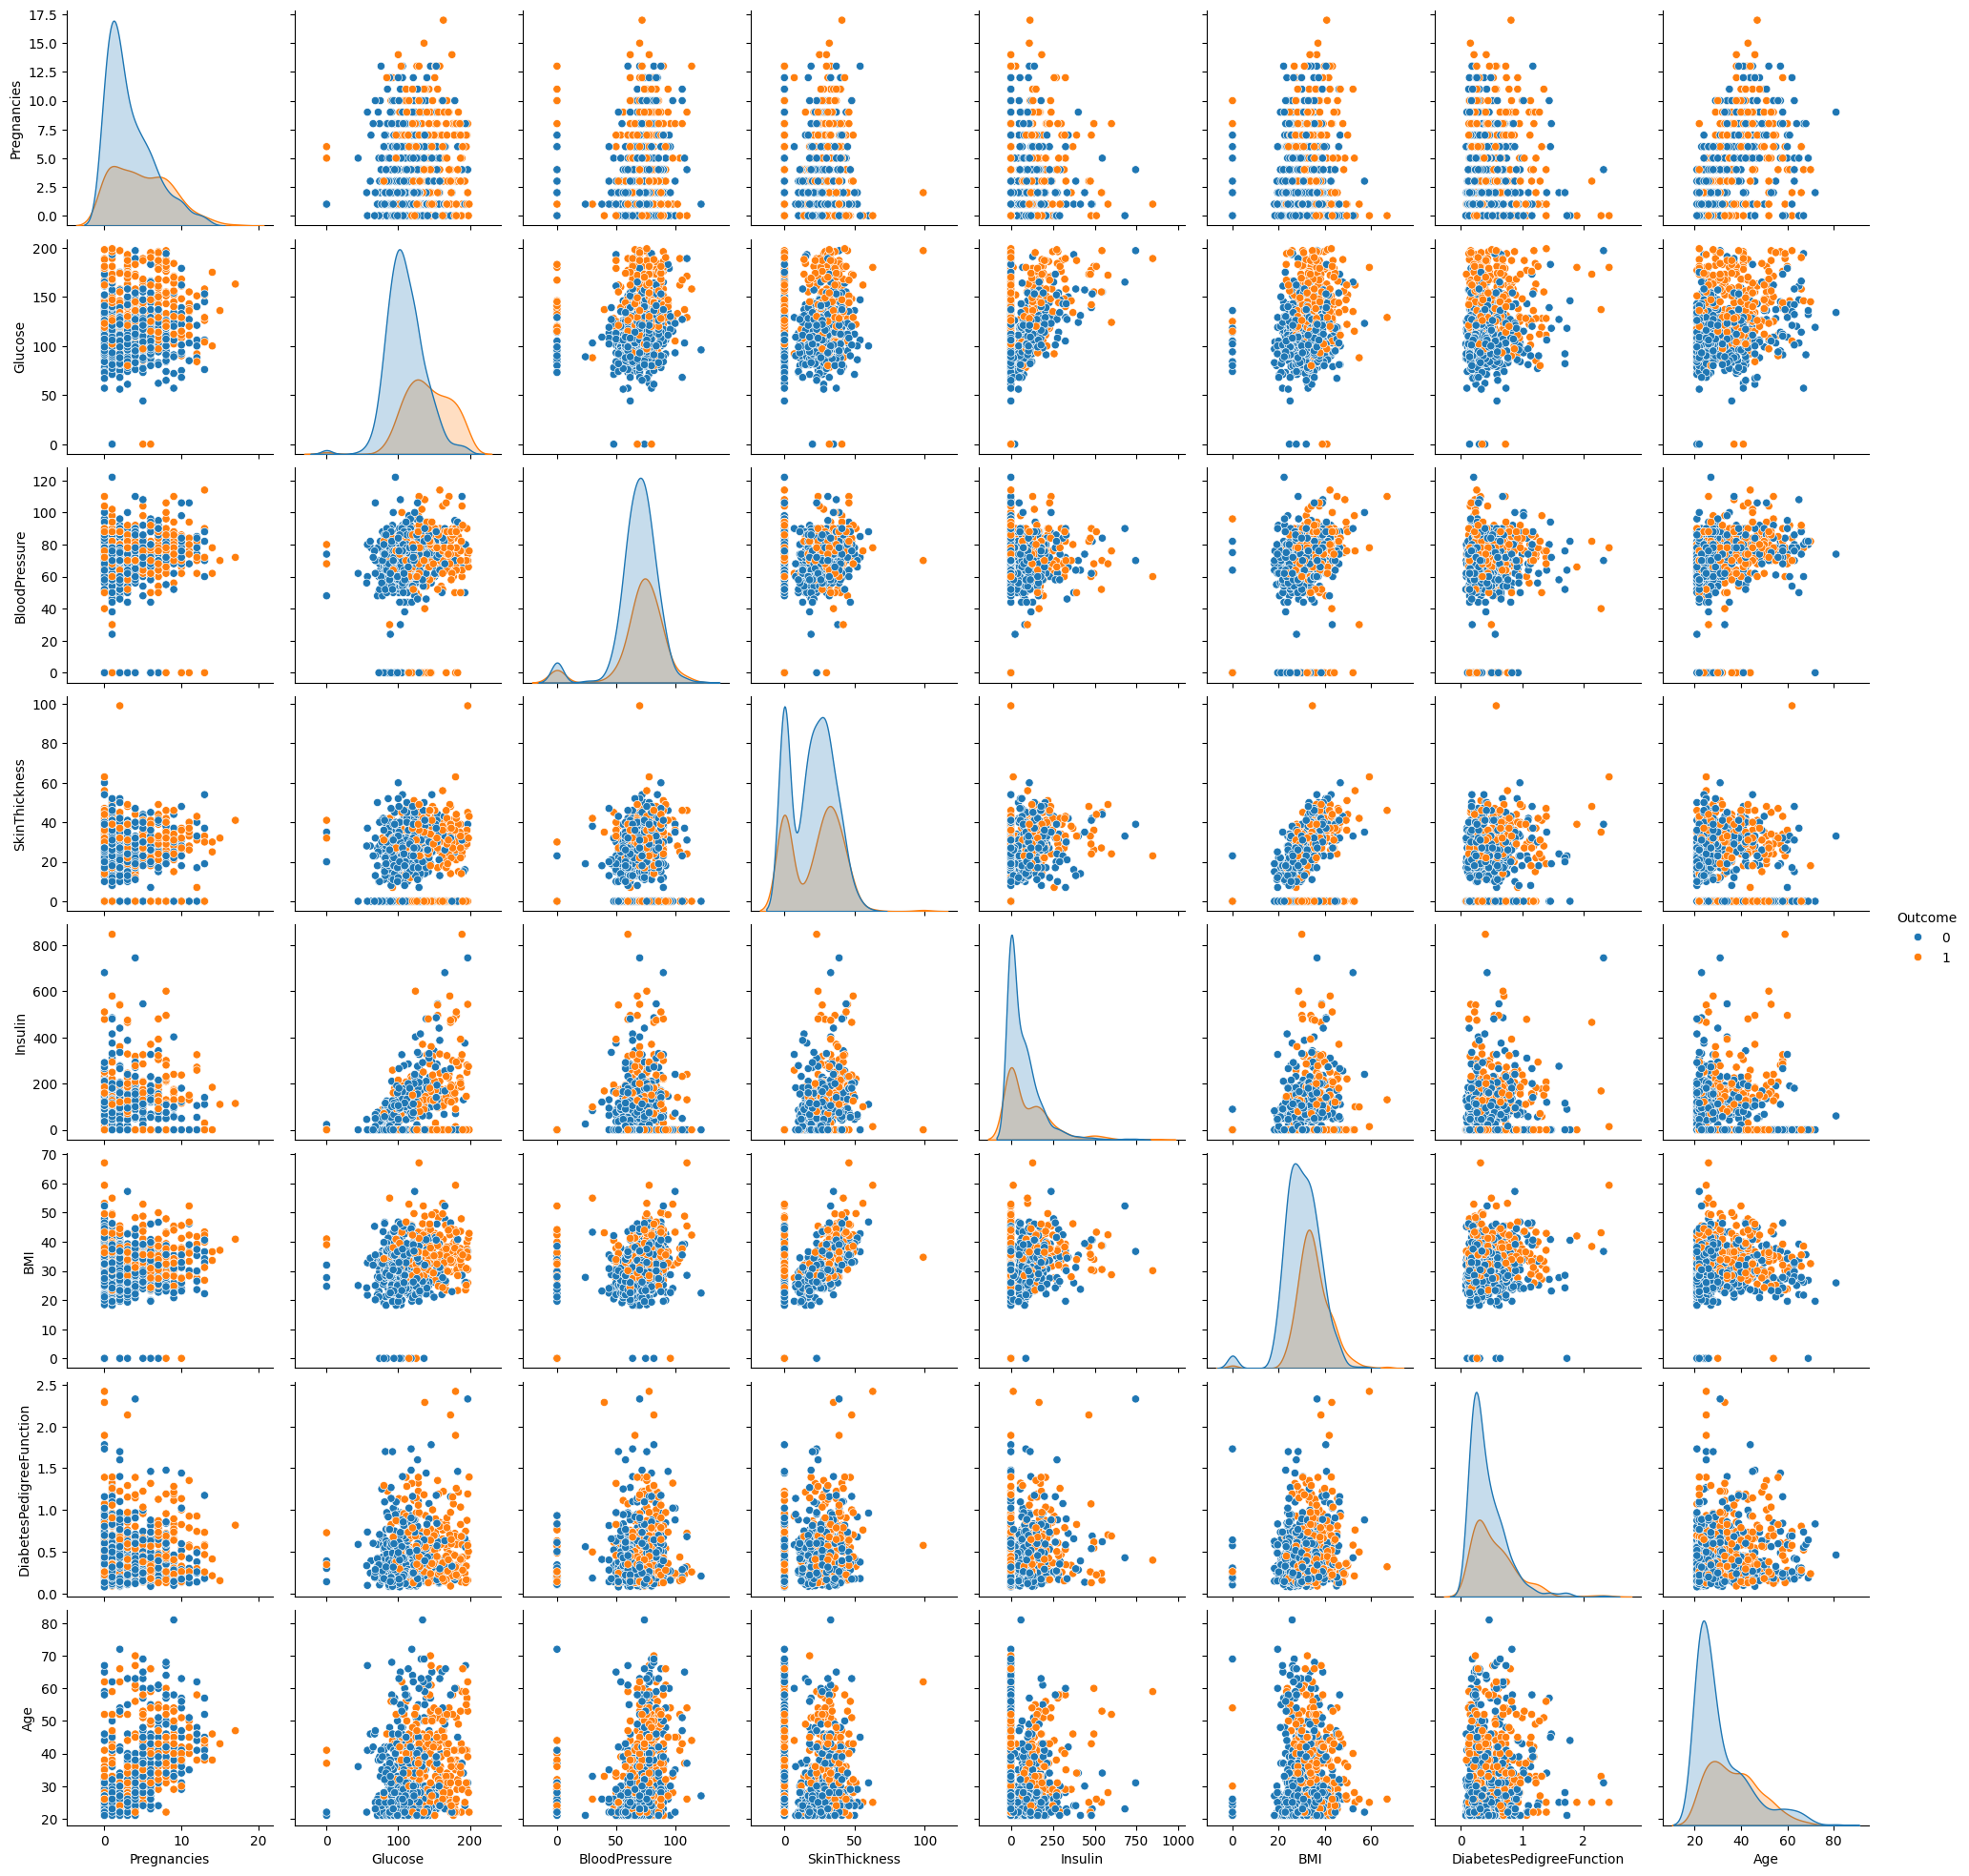

In [13]:
sns.pairplot(dbts_raw, hue='Outcome')
plt.show()

### How is the relationship between all variables (**excludes** missings)?

*   Extreme values detected  for pedigree diabetes variable > 2
*   Extreme value detected for skin thickness > 90
*   Positive association between skin thickness and BMI (expected)
*   After excluding missing values, the relationship between gluclose and blood pressure seems to be non-linear



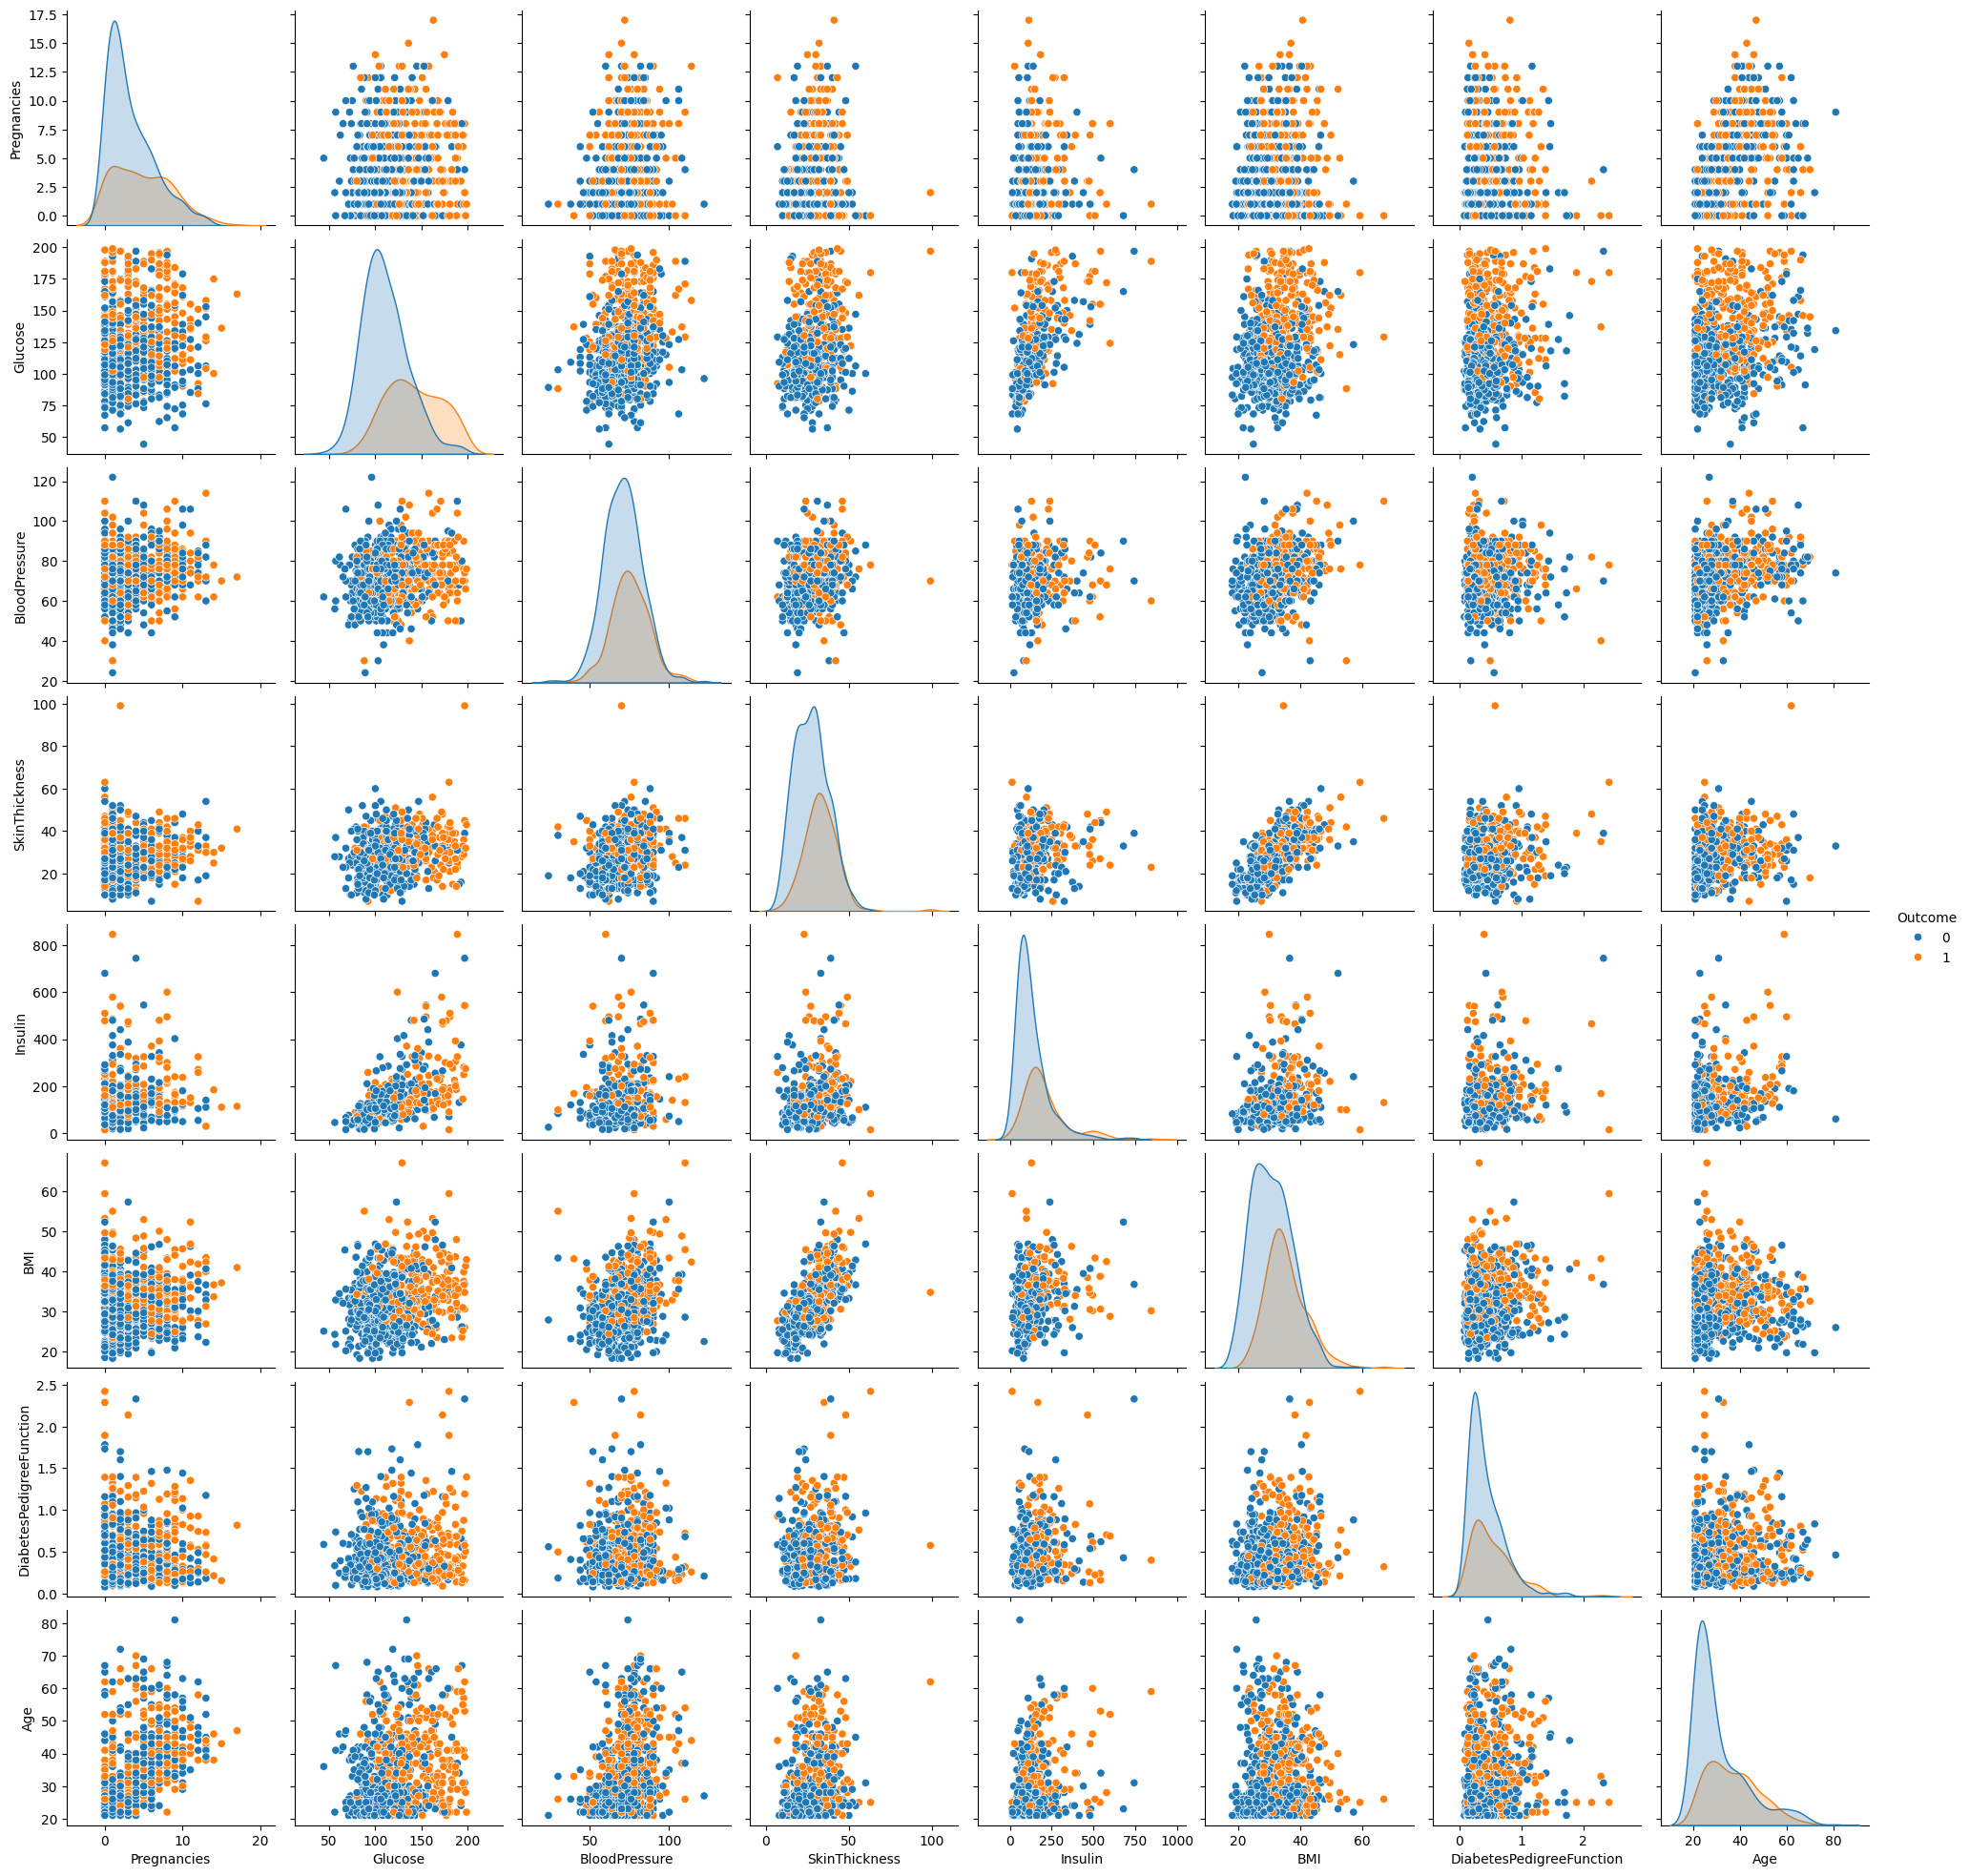

In [14]:
sns.pairplot(dbts_int, hue='Outcome')
plt.show()

### Parallell coordinates

Although all variables are in different ranges, it is possible to differentiate that patientes diagnosed with diabetes have higher number of pregnancies, glucose, blood pressure, insulin, and BMI

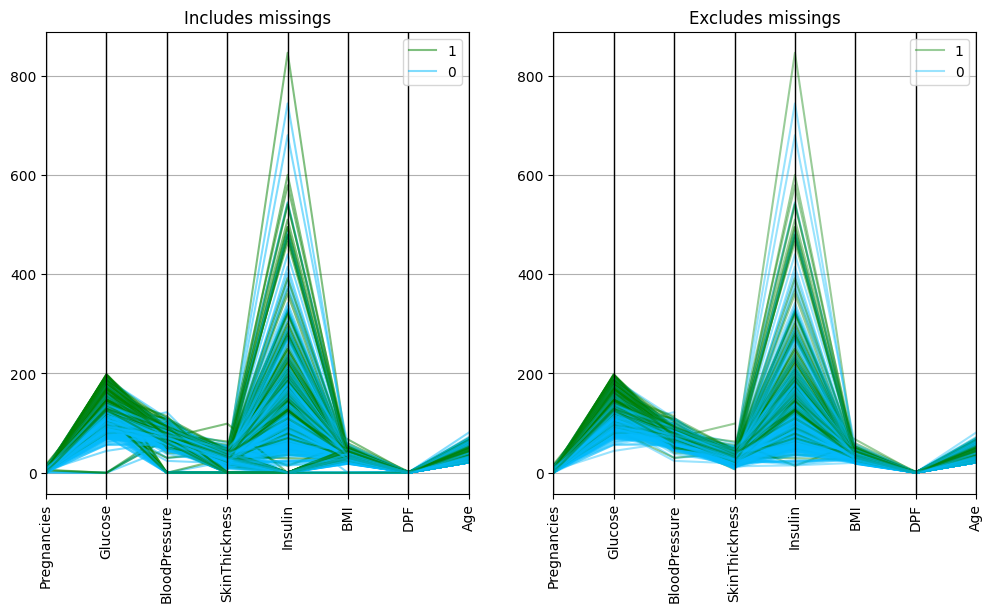

In [15]:
#renaming DiabetesPedigreeFunction to fit it better in the graph
dbts_raw2 = dbts_raw.rename(columns={'DiabetesPedigreeFunction': 'DPF'})
dbts_int2 = dbts_int.rename(columns={'DiabetesPedigreeFunction': 'DPF'})

fig, ax = plt.subplots(1,2, figsize=(12, 6))

pd.plotting.parallel_coordinates(dbts_raw2, 'Outcome', color=('Green', '#03bafc' ), alpha=0.5,ax=ax[0])
ax[0].set_title('Includes missings')
ax[0].tick_params(axis='x', rotation=90)

pd.plotting.parallel_coordinates(dbts_int2, 'Outcome', color=('Green', '#03bafc' ), alpha=0.4, ax=ax[1])
ax[1].set_title('Excludes missings')
ax[1].tick_params(axis='x', rotation=90)

plt.show()

# Data cleaning

After analising the data, the following observations and/or variables will be excluded/recoded:

*   Recode extreme values detected for pedigree diabetes variable >= 2 using inter quartile range (IQR) method

*   Recode extreme value detected for skin thickness > 90 using IQR

*   The variable insuline will be excluded. Medical practicioners do not measure the levels of insuline to diagnose a patient with diabetes despite levels of insuline and glucose are related. According to the American Diabetes Association (ADA), three criteria can be used to diagnose this condition (more info [here](https://diabetes.org/about-diabetes/diagnosis)):

> 1. The average measure of blood glucose over the last 2-3 months
> 2. Fasting blood glucose levels
> 3. Oral Glucose Tolerance Test measure two hours after

Criteria #3 is the one available in the data, hence, the variable of glucose will remain while insuline will be excluded

In [16]:
print('Number of observations with values of DiabetesPedigreeFunction>=2 : ', len(dbts_int[dbts_int['DiabetesPedigreeFunction']>=2]))
print('Number of observations with values of SkinThickness>=90 : ', len(dbts_int[dbts_int['SkinThickness']>=90]))


Number of observations with values of DiabetesPedigreeFunction>=2 :  4
Number of observations with values of SkinThickness>=90 :  1


First checking how the summary statistics change before recoding:

In [17]:
dbts_int[['DiabetesPedigreeFunction', 'SkinThickness']].describe().T

count       mean        std    min       25%  \
DiabetesPedigreeFunction  768.0   0.471876   0.331329  0.078   0.24375   
SkinThickness             541.0  29.153420  10.476982  7.000  22.00000   

                              50%       75%    max  
DiabetesPedigreeFunction   0.3725   0.62625   2.42  
SkinThickness             29.0000  36.00000  99.00

In [18]:
#Calculating IQR for DiabetesPedigreeFunction :
diab_75=np.percentile(dbts_int['DiabetesPedigreeFunction'], 75)
diab_iqr=diab_75-np.percentile(dbts_int['DiabetesPedigreeFunction'], 25)

#recoding extreme values:
dbts_int.loc[dbts_int['DiabetesPedigreeFunction']>=2,'DiabetesPedigreeFunction']=diab_75+diab_iqr

#Calculating IQR for SkinThickness :
skin_75=np.percentile(dbts_int['SkinThickness'], 75)
skin_iqr=skin_75-np.percentile(dbts_int['SkinThickness'], 25)

#recoding extreme values:
dbts_int.loc[dbts_int['SkinThickness']>=90, 'SkinThickness']=diab_75+diab_iqr

Checking the recoding worked:

In [19]:
print('Number of observations with values of DiabetesPedigreeFunction>=2 : ', len(dbts_int[dbts_int['DiabetesPedigreeFunction']>=2]))
print('Number of observations with values of SkinThickness>=90 : ', len(dbts_int[dbts_int['SkinThickness']>=90]))

Number of observations with values of DiabetesPedigreeFunction>=2 :  0
Number of observations with values of SkinThickness>=90 :  0


Checking how the summary stats change after recoding: values do not vary by much after recoding extreme values, which may signal that the recoding did not have a major effect on how the variable distributes

In [20]:
dbts_int[['DiabetesPedigreeFunction', 'SkinThickness']].describe().T

count       mean        std      min       25%  \
DiabetesPedigreeFunction  768.0   0.465185   0.306394  0.07800   0.24375   
SkinThickness             541.0  28.972290  10.107761  1.00875  22.00000   

                              50%       75%     max  
DiabetesPedigreeFunction   0.3725   0.62625   1.893  
SkinThickness             29.0000  36.00000  63.000

Dropping insuline:

In [21]:
dbts_int.drop('Insulin', axis=1, inplace=True)

## Splitting data

*   The remaining missing data for blood pressure, BMI, and skin thickness will be replaced using interpolation:

In [22]:
dbts_int.isnull().sum().sort_values(ascending=False)

SkinThickness               227
BloodPressure                35
BMI                          11
Glucose                       5
Pregnancies                   0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

To reduce bias in the testing sample (e.g., data leakage), first the data will be separated into test and train and then the interpolation will be performed

In [23]:
X=dbts_int.drop('Outcome', axis=1)
y=dbts_int['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Both y train and test have a similar percentage of patients diagnosed with diabetes

In [24]:
print(y_train.mean())
print(y_test.mean())

0.3469055374592834
0.35714285714285715


The sklearn.impute.IterativeImputer will be used to fill missing values. This strategy fills missing values by setting the variable with missings as output and using the other variables as inputs

In [25]:
imp = IterativeImputer(skip_complete=True, random_state=42)
X_train_nn=pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test_nn=pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

dump(imp, open('/workspaces/Decis_Tree_Diabetes/models/int_seed42_skipTrue.pk', 'wb'))

Summary stats before and after missing imputation do not change by much

In [26]:
missing=['SkinThickness', 'BloodPressure','BMI','Glucose']
X_train[missing].describe().T

count        mean        std   min    25%    50%    75%    max
SkinThickness  438.0   28.595890   9.960502   8.0   21.0   28.5   36.0   63.0
BloodPressure  590.0   72.238983  12.343231  24.0   64.0   72.0   80.0  122.0
BMI            607.0   32.352224   6.975458  18.2   27.3   32.0   36.5   67.1
Glucose        609.0  121.847291  30.225545  44.0  100.0  118.0  139.0  199.0

In [27]:
X_train_nn[missing].describe().T

count        mean        std   min      25%    50%         75%  \
SkinThickness  614.0   28.368047   9.078038   8.0   22.000   28.0   34.798881   
BloodPressure  614.0   72.173243  12.143953  24.0   64.000   72.0   80.000000   
BMI            614.0   32.341933   6.937817  18.2   27.325   32.0   36.375000   
Glucose        614.0  121.820938  30.121496  44.0  100.000  118.0  139.000000   

                 max  
SkinThickness   63.0  
BloodPressure  122.0  
BMI             67.1  
Glucose        199.0

Storing train and test data

In [28]:
X_train.to_csv('/workspaces/Decis_Tree_Diabetes/data/interim/X_train.csv', index=False)
X_test.to_csv('/workspaces/Decis_Tree_Diabetes/data/interim/X_test.csv', index=False)

open("/workspaces/Decis_Tree_Diabetes/data/processed/y_train.txt", "w").write(y_train.to_string(index=False))
open("/workspaces/Decis_Tree_Diabetes/data/processed/y_test.txt", "w").write(y_test.to_string(index=False))

#Train and test with no-nulls (nn)
X_train_nn.to_csv('/workspaces/Decis_Tree_Diabetes/data/processed/X_train_nn.csv', index=False)
X_test_nn.to_csv('/workspaces/Decis_Tree_Diabetes/data/processed/X_test_nn.csv', index=False)
